In [1]:
import time
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.autonotebook import tqdm
from scipy.spatial.distance import cdist

from sklearn.metrics import precision_recall_fscore_support,confusion_matrix, jaccard_score

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
img_size = 68

batch_size = 32
learning_rate = 0.2

In [4]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform = None):
        self.img = img_dir
        self.mask = mask_dir
        self.transform = transform
        self.imgpath = os.listdir(img_dir)
        self.mskpath = os.listdir(mask_dir)

    def __len__(self):
        return len(self.imgpath)
        
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img, self.imgpath[index])
        mask_path = os.path.join(self.mask, self.mskpath[index])

        image = cv.resize(cv.imread(img_path,cv.IMREAD_GRAYSCALE),(img_size,img_size))
        mask = cv.resize(cv.imread(mask_path,cv.IMREAD_GRAYSCALE),(img_size,img_size)) 
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return (image, mask)

In [5]:
path_data_train = "C:/Users/sonbu/Desktop/LVTN/Dataset/LiTS17/Images"
path_mask_train = "C:/Users/sonbu/Desktop/LVTN/Dataset/LiTS17/Masks"

dataset = CustomDataset(img_dir = path_data_train, mask_dir = path_mask_train,transform = transforms.ToTensor())

In [6]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [7]:
def create_adj_matrix(size):
    
    col, row = np.meshgrid(np.arange(size), np.arange(size))
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / size
    dist = torch.from_numpy(cdist(coord, coord)).float().to(device)
    sigma_dist = torch.var(dist)

    A = torch.exp(-dist**2 / sigma_dist)
    A[A <= 0.00001] = 0
    
    D = torch.diag(torch.sum(A, axis=1))
    D_hat = torch.sqrt(torch.linalg.inv(D))

    A_hat =  torch.matmul(D_hat, torch.matmul(A, D_hat))
    
    return A_hat

adj = create_adj_matrix(size=img_size)
print(adj)

tensor([[0.0042, 0.0041, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
        [0.0041, 0.0039, 0.0038,  ..., 0.0000, 0.0000, 0.0000],
        [0.0039, 0.0038, 0.0037,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0037, 0.0038, 0.0039],
        [0.0000, 0.0000, 0.0000,  ..., 0.0038, 0.0039, 0.0041],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0041, 0.0042]],
       device='cuda:0')


In [8]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.projection = nn.Linear(in_features, out_features, bias=False)

    def forward(self, input, adj):
        batch_size = input.size(0)
        support = self.projection(input)
        output = torch.stack([torch.mm(adj, support[b]) for b in range(batch_size)])
        return output

In [9]:
class GCNN(nn.Module):
    def __init__(self, img_size, in_features, adj):
        super().__init__()
        self.N = img_size ** 2
        self.adj = nn.Parameter(adj)
        self.gc1 = GraphConvolution(in_features, 4)
        self.gc2 = GraphConvolution(4, 3)
        self.gc3 = GraphConvolution(3, 1)

    def forward(self, x):
        x = F.leaky_relu(self.gc1(x, self.adj))
        x = F.leaky_relu(self.gc2(x, self.adj))
        x = self.gc3(x, self.adj)
        return torch.sigmoid(x)

In [10]:
model = GCNN(img_size=img_size, in_features=1, adj = adj).to(device)

model.load_state_dict(torch.load('C:/Users/sonbu/Desktop/LVTN/Model/GCNN/GCNN_LiTS17.pt'))

optimizer = optim.SGD(model.parameters(), lr= learning_rate)
loss_func = nn.BCELoss()

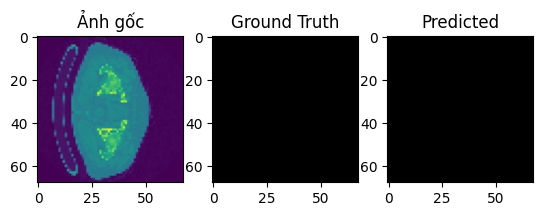

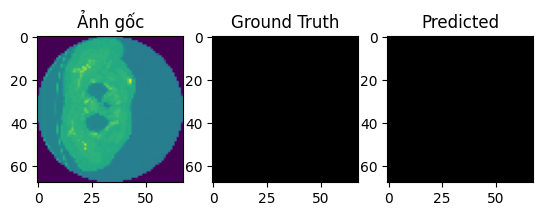

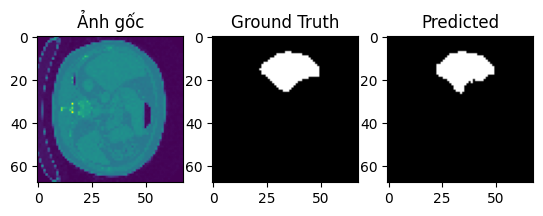

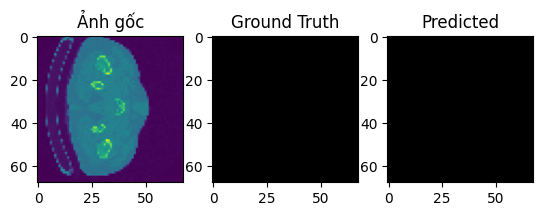

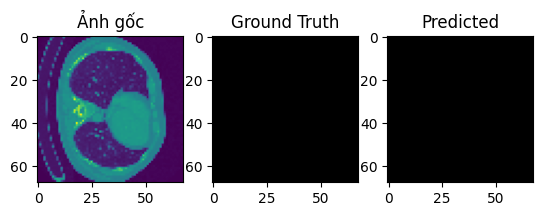

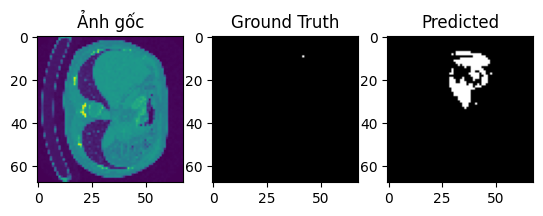

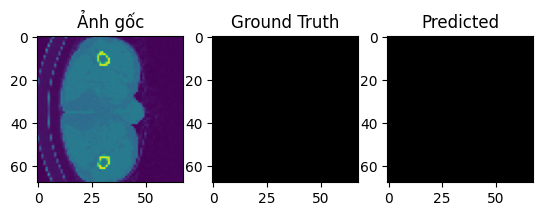

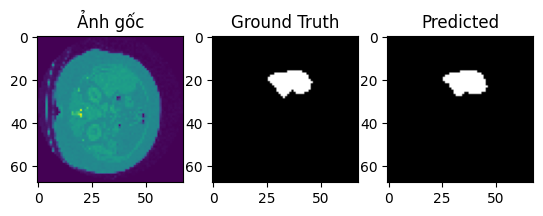

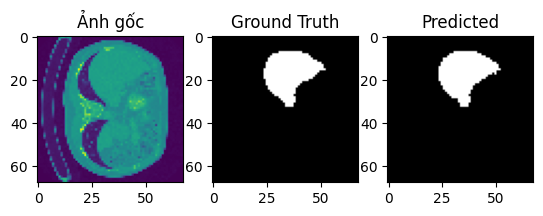

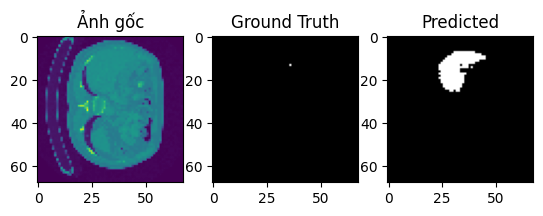

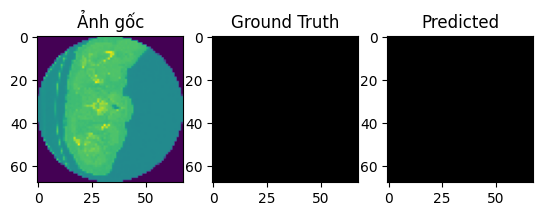

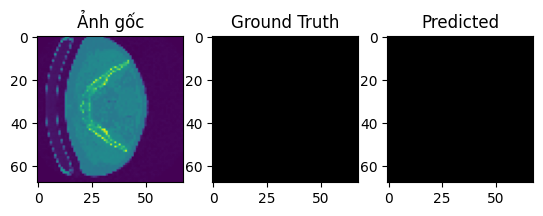

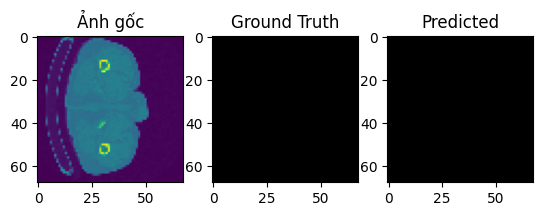

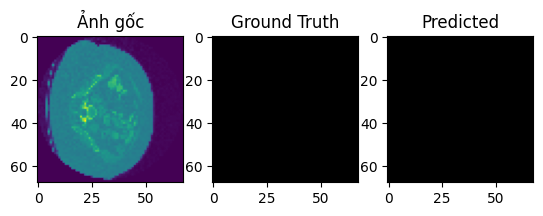

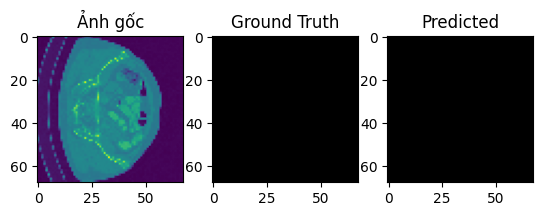

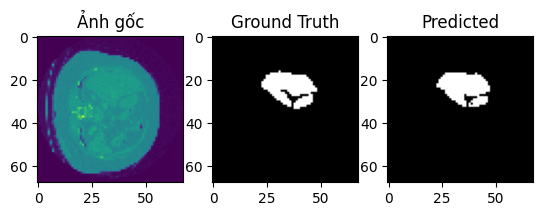

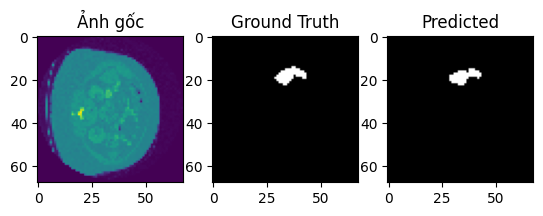

Accurcy: 99.53 - DSC: 80.29% - PRE: 71.23% - SEN: 93.94% - SPE: 99.59%


In [11]:
test_accuracy, pre, sen, dsc, spe, iou = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
length_data = len(test_loader)

model.eval()
with torch.no_grad():
    for batch_id, (data, label) in enumerate(test_loader):
        batch_size = data.size(0)
        start = time.time()
        data, label = data.to(device), label.to(device)
        data = data.permute(0, 2, 3, 1).view(batch_size, -1, 1)
        label = label.view(batch_size, -1, 1)
        pred = model(data)
        loss = loss_func(pred, label)
        
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        lb = label
        lb[lb > 0.5] = 1
        lb[lb <= 0.5] = 0
       
    
        total_test= lb.numel()
        correct_test = pred.eq(lb).sum().item()
        test_accuracy += (float(correct_test*100) / total_test)

        precision,recall, f1_score, sup = precision_recall_fscore_support(lb.view(-1, 1).cpu().numpy(), pred.view(-1, 1).cpu().numpy(),zero_division=1, average='binary')
        cm = confusion_matrix(lb.view(-1, 1).cpu().numpy(), pred.view(-1, 1).cpu().numpy())
        specificity = cm[0,0]/(cm[0,0]+cm[0,1])
        iou_score = jaccard_score(lb.view(-1, 1).cpu().numpy(), pred.view(-1, 1).cpu().numpy())
        pre += precision
        sen += recall
        dsc += f1_score
        spe += specificity
        
        #print('IoU: {:.2f}%'.format(iou_score*100))
        
        plt.figure()
        plt.subplot(131)
        plt.title("Ảnh gốc")
        plt.imshow(data[0].view(img_size, img_size).cpu().detach().numpy())
        plt.subplot(132)
        plt.title("Ground Truth")
        plt.imshow(label[0].view(img_size, img_size).cpu().detach().numpy(), cmap='gray')
        plt.subplot(133)
        plt.title("Predicted")
        plt.imshow(pred[0].view(img_size, img_size).cpu().detach().numpy(), cmap='gray')
        plt.show()
    
    print('Accurcy: {:.2f} - DSC: {:.2f}% - PRE: {:.2f}% - SEN: {:.2f}% - SPE: {:.2f}%'.format(test_accuracy /length_data, dsc*100/length_data, pre*100/length_data, sen*100/length_data, spe*100/length_data))